# Using shapefiles to calculate zonal statistics

## Loading libraries

In [1]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
import cmocean as cm                              # Nice colormaps
import cartopy.crs as ccrs                        # For making maps with different projections
import cartopy.feature as cft                     # For adding features to maps
import copy
import calendar
import matplotlib.gridspec as gridspec            # To create grids inside plots
import matplotlib.ticker as ticker                # To change ticks in plot axes
import os
import re
#Importing script containing functions developed to calculate timeseries
import ZonalStatsFunctions as zsf

#Libraries used in zonal statistics calculations
import rasterio
import geopandas
import rasterio.plot
import rioxarray
from shapely.geometry import mapping, Polygon

In [2]:
client = Client(n_workers = 12)

In [3]:
session = cc.database.create_session()

## Accessing ACCESS-OM2-01 model outputs
This script uses cycle 2 model outputs to calculate variable means using a shapefile

In [30]:
#Set up variables
#Experiment
exp = "01deg_jra55v140_iaf_cycle2"

#Variable of interest
# varInt = 'surface_temp' #SST
# varInt = 'surface_salt' #Salinity
varInt = 'mld' #MLD

In [5]:
#Querying experiment variables
expvar = cc.querying.get_variables(session, exp)
#Extract variables with keywords included in its long_name column
#force all letters to be lowercase to get matches
# expvar.dropna()[expvar['long_name'].dropna().str.lower().str.match(".*mixed layer.*")] 
expvar.dropna()[expvar['name'].dropna().str.lower().str.match(".*mld.*")] 
# expvar

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
50,mld,mixed layer depth determined by density criteria,1 daily,output487/ocean/ocean-2d-mld-1-daily-mean-ym_2...,244,1958-01-01 00:00:00,2019-01-01 00:00:00
181,mld,mixed layer depth determined by density criteria,1 monthly,output487/ocean/ocean-2d-mld-1-monthly-mean-ym...,244,1958-01-01 00:00:00,2019-01-01 00:00:00
182,mld_max,mixed layer depth determined by density criteria,1 monthly,output487/ocean/ocean-2d-mld-1-monthly-max-ym_...,244,1958-01-01 00:00:00,2019-01-01 00:00:00


In [5]:
#Give the start and end dates for the analyses. The input must be given as a list, even if it is one item only.
#Dates can be given as full date (e.g., 2010-01-01), just year and month, or just year. If multiple years are to be analysed, ensure both variables have the same length
#Start date
stime = [str(i)+'-12-01' for i in range(1964, 2018, 1)]
#End date
etime = [str(i)+'-11-30' for i in range(1965, 2019, 1)]
#Define frequency. Remember to check frequency and variable of interest are related to each other, for example, aice_m has a monthly frequency, while aice has a daily frequency.
freq = '1 daily'

### Loading data
**Accessing variable of interest**

In [31]:
SO_SST = zsf.getACCESSdata(varInt, stime[0], etime[-1], freq = freq, ses = session)
SO_SST

<xarray.DataArray 'mld' (time: 351, yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(351, 740, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
  * time      (time) datetime64[ns] 1978-10-16T12:00:00 ... 2007-12-16T12:00:00
Attributes:
    long_name:      mixed layer depth determined by density criteria
    units:          m
    valid_range:    [      0. 1000000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    time_bounds:    <xarray.DataArray 'time_bounds' (time: 351, nv: 2)>\ndask...

**Accessing area per pixel to calculate weights**

In [7]:
#Loading ocean area to create weights
area =  cc.querying.getvar(exp, 'area_t', session, frequency = 'static', n = -1)
area = area.sel(yt_ocean = slice(-90, -45))
area

<xarray.DataArray 'area_t' (yt_ocean: 740, xt_ocean: 3600)>
dask.array<getitem, shape=(740, 3600), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t

## Correcting longitude values in ACCESS-OM2-01 model outputs
Model outputs for ACCESS-OM2-01 range from -280 to +80, which causes problems with trying to perform spatial analyses on this data. To avoid issues, longitude values need to be corrected so they range between -180 and +180. This correction require several steps as there is no way to perform a simple conversion using `xr.assign_coords` or `xr.where`.  
  
The `corrlong` function defined below will perform this corrections easily. The only input required is the dataset that needs longitude correction. It will return a the same data array with longitude values ranging from -180 to +180.

In [8]:
#Correcting data array containing variable of interest and area per pixel
SO_SSTc = zsf.corrlong(SO_SST-273.15) #SST
# SO_SSTc = zsf.corrlong(SO_SST)
area_c = zsf.corrlong(area)

# Calculating zonal statistics on a data array using a shapefile

### Loading the shapefiles
The shapefile being used must have decimal degrees as units, so it matches ACCESS-OM2-01 outputs. Any shapefile can be used to calculate zonal statistics.  
If the shapefiles contain multiple areas of interest, these areas need to be included under a column called `SectorName` to perform calculations within each sector.

In [12]:
#Access shapefile containing the boundaries being used to calculate zonal statistics - Include the entire file path to the shapefile
#Polar regions (continental and deep water areas)
regions = geopandas.read_file(r'/g/data/v45/la6889/GIS_DataBase/Shapefiles/ACE_ecostasts/aes_polar_regions_simple_no_islands_wgs84.shp')

#Subsetting shapefiles into sectors
Ind_sector = regions.query('SectorName == "{}"'.format(sorted(regions.SectorName.values)[2]))
WP_sector = regions.query('SectorName == "{}"'.format(sorted(regions.SectorName.values)[3]))
EP_sector = regions.query('SectorName == "{}"'.format(sorted(regions.SectorName.values)[1]))
Atl_sector = regions.query('SectorName == "{}"'.format(sorted(regions.SectorName.values)[0]))

#Polar continental shelf
# regions = geopandas.read_file(r'/g/data/v45/la6889/GIS_DataBase/Shapefiles/ACE_ecostasts/aes_zones_WGS84.shp')
# regions = regions.query("Zone == 'Continent'")
# regions

In [ ]:
# Plot shapefile over the raster to ensure they both have the same CRS and cover the same area
#Initialise figure
fig, ax = plt.subplots(figsize = (15, 15))

#Plot just one timestep of the data array
SO_SSTc[0].plot(ax = ax, add_colorbar = False)
#Plot shapefile over the top and show each sector in different colour
regions.plot(ax = ax, column = 'SectorName', legend = True, alpha = 0.5, edgecolor = 'black')

### Clipping data arrays

Note that if a shapefile includes multiple regions of interest, the resulting clipped area will cover the entire shapefile. It will not clip the data array per region in the shapefile. If the data array needs to be clipped per region, that specific region needs to be selected.

In [10]:
#Clipping data arrays
Indian = zsf.clipDataArray(SO_SSTc, shp = Ind_sector)
Indian_a = zsf.clipDataArray(area_c, shp = Ind_sector)

WestPacific = zsf.clipDataArray(SO_SSTc, shp = WP_sector)
WP_a = zsf.clipDataArray(area_c, shp = WP_sector)

EastPacific = zsf.clipDataArray(SO_SSTc, shp = EP_sector)
EP_a = zsf.clipDataArray(area_c, shp = EP_sector)

Atlantic = zsf.clipDataArray(SO_SSTc, shp = Atl_sector)
Atlantic_a = zsf.clipDataArray(area_c, shp = Atl_sector)

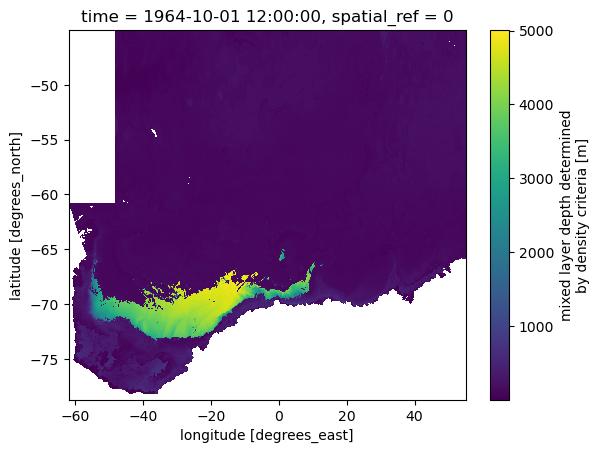

In [16]:
#Checking resulting clip
Atlantic[0].plot()

## Calculating weighted means by sector

### Yearly seasonal

#### Weighted means per sector

In [194]:
#Create an empty list that will contain calculations for every year
# file_out = r'/g/data/v45/la6889/Calculations/MLD/YearlySeasonal/Means'
file_out = r'/g/data/v45/la6889/Calculations/SST/YearlySeasonal/Means'

#Loop for every year included in the analysis
for i in np.arange(0, len(stime)):
    #From the clipped data select one year to calculate the weighted seasonal means
    x = zsf.weightedMeans(Indian.sel(time = slice(stime[i], etime[i])), Indian_a, meanby = 'season')
    x_w = zsf.addTimeYear(x, etime[i].split('-')[0])
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlySeasonalMeans_Indian_' + stime[i].split('-')[0] + '-' + etime[i].split('-')[0] + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_YearlySeasonalMeans_Indian_' + stime[i].split('-')[0] + '-' + etime[i].split('-')[0] + '.nc')))

In [195]:
for i in np.arange(0, len(stime)):
    x = zsf.weightedMeans(WestPacific.sel(time = slice(stime[i], etime[i])), WP_a, meanby = 'season')
    x_w = zsf.addTimeYear(x, etime[i].split('-')[0])
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlySeasonalMeans_WestPacific_' + stime[i].split('-')[0] + '-' + etime[i].split('-')[0] + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_YearlySeasonalMeans_WestPacific_' + stime[i].split('-')[0] + '-' + etime[i].split('-')[0] + '.nc')))

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [196]:
for i in np.arange(0, len(stime)):
    x = zsf.weightedMeans(EastPacific.sel(time = slice(stime[i], etime[i])), EP_a, meanby = 'season')
    x_w = zsf.addTimeYear(x, etime[i].split('-')[0])
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlySeasonalMeans_EastPacific_' + stime[i].split('-')[0] + '-' + etime[i].split('-')[0] + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_YearlySeasonalMeans_EastPacific_' + stime[i].split('-')[0] + '-' + etime[i].split('-')[0] + '.nc')))

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [197]:
for i in np.arange(0, len(stime)):
    x = zsf.weightedMeans(Atlantic.sel(time = slice(stime[i], etime[i])), Atlantic_a, meanby = 'season')
    x_w = zsf.addTimeYear(x, etime[i].split('-')[0])
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlySeasonalMeans_Atlantic_' + stime[i].split('-')[0] + '-' + etime[i].split('-')[0] + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_YearlySeasonalMeans_Atlantic_' + stime[i].split('-')[0] + '-' + etime[i].split('-')[0] + '.nc')))

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

#### Maximum values per sector

In [12]:
#Create an empty list that will contain calculations for every year
file_out = r'/g/data/v45/la6889/Calculations/MLD/YearlySeasonal/Max'

#Loop for every year included in the analysis
for i in np.arange(0, len(stime)):
    #From the clipped data select one year to calculate the weighted seasonal means
    x = Indian.sel(time = slice(stime[i], etime[i])).groupby('time').max(('xt_ocean', 'yt_ocean')).groupby('time.season').max()
    x_w = zsf.addTimeYear(x, etime[i].split('-')[0])
    os.makedirs(file_out, exist_ok = True)
    x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlySeasonalMax_Indian_' + stime[i].split('-')[0] + '-' + etime[i].split('-')[0] + '.nc')))

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [17]:
for i in np.arange(0, len(stime)):
    x = WestPacific.sel(time = slice(stime[i], etime[i])).groupby('time').max(('xt_ocean', 'yt_ocean')).groupby('time.season').max()
    x_w = zsf.addTimeYear(x, etime[i].split('-')[0])
    os.makedirs(file_out, exist_ok = True)
    x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlySeasonalMax_WestPacific_' + stime[i].split('-')[0] + '-' + etime[i].split('-')[0] + '.nc')))

In [18]:
for i in np.arange(0, len(stime)):
    x = EastPacific.sel(time = slice(stime[i], etime[i])).groupby('time').max(('xt_ocean', 'yt_ocean')).groupby('time.season').max()
    x_w = zsf.addTimeYear(x, etime[i].split('-')[0])
    os.makedirs(file_out, exist_ok = True)
    x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlySeasonalMax_EastPacific_' + stime[i].split('-')[0] + '-' + etime[i].split('-')[0] + '.nc')))

In [19]:
for i in np.arange(0, len(stime)):
    x = Atlantic.sel(time = slice(stime[i], etime[i])).groupby('time').max(('xt_ocean', 'yt_ocean')).groupby('time.season').max()
    x_w = zsf.addTimeYear(x, etime[i].split('-')[0])
    os.makedirs(file_out, exist_ok = True)
    x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlySeasonalMax_Atlantic_' + stime[i].split('-')[0] + '-' + etime[i].split('-')[0] + '.nc')))

### Yearly monthly

#### Weighted means per sector

In [13]:
#Create an empty list that will contain calculations for every year
# file_out = r'/g/data/v45/la6889/Calculations/MLD/YearlyMonthly/Means'
file_out = r'/g/data/v45/la6889/Calculations/SST/YearlyMonthly/Means'
years = range(1965, 2019, 1)

#Loop for every year included in the analysis
for yr in years:
    #From the clipped data select one year to calculate the weighted seasonal means
    x = zsf.weightedMeans(Indian.sel(time = str(yr)), Indian_a, meanby = 'month')
    x_w = zsf.addTimeYear(x, yr, by = 'month')
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlyMonthlyMeans_Indian_' + str(yr) + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_YearlyMonthlyMeans_Indian_' + str(yr) + '.nc')))

In [14]:
for yr in years:
    x = zsf.weightedMeans(WestPacific.sel(time = str(yr)), WP_a, meanby = 'month')
    x_w = zsf.addTimeYear(x, yr, by = 'month')
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlyMonthlyMeans_WestPacific_' + str(yr) + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_YearlyMonthlyMeans_WestPacific_' + str(yr) + '.nc')))

In [15]:
for yr in years:
    x = zsf.weightedMeans(EastPacific.sel(time = str(yr)), EP_a, meanby = 'month')
    x_w = zsf.addTimeYear(x, yr, by = 'month')
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlyMonthlyMeans_EastPacific_' + str(yr) + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_YearlyMonthlyMeans_EastPacific_' + str(yr) + '.nc')))

In [16]:
for yr in years:
    x = zsf.weightedMeans(Atlantic.sel(time = str(yr)), Atlantic_a, meanby = 'month')
    x_w = zsf.addTimeYear(x, yr, by = 'month')
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlyMonthlyMeans_Atlantic_' + str(yr) + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_YearlyMonthlyMeans_Atlantic_' + str(yr) + '.nc')))

#### Maximum values per sector

In [19]:
#Create an empty list that will contain calculations for every year
file_out = r'/g/data/v45/la6889/Calculations/MLD/YearlyMonthly/Max'
years = range(1965, 2019, 1)

#Loop for every year included in the analysis
for yr in years:
    #From the clipped data select one year to calculate the weighted seasonal means
    x = Indian.sel(time = str(yr)).groupby('time').max(('xt_ocean', 'yt_ocean')).groupby('time.month').max()
    x_w = zsf.addTimeYear(x, yr, by = 'month')
    os.makedirs(file_out, exist_ok = True)
    x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlyMonthlyMax_Indian_' + str(yr) + '.nc')))

In [20]:
for yr in years:
    x = WestPacific.sel(time = str(yr)).groupby('time').max(('xt_ocean', 'yt_ocean')).groupby('time.month').max()
    x_w = zsf.addTimeYear(x, yr, by = 'month')
    os.makedirs(file_out, exist_ok = True)
    x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlyMonthlyMax_WestPacific_' + str(yr) + '.nc')))

In [21]:
for yr in years:
    x = EastPacific.sel(time = str(yr)).groupby('time').max(('xt_ocean', 'yt_ocean')).groupby('time.month').max()
    x_w = zsf.addTimeYear(x, yr, by = 'month')
    os.makedirs(file_out, exist_ok = True)
    x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlyMonthlyMax_EastPacific_' + str(yr) + '.nc')))

In [22]:
for yr in years:
    x = Atlantic.sel(time = str(yr)).groupby('time').max(('xt_ocean', 'yt_ocean')).groupby('time.month').max()
    x_w = zsf.addTimeYear(x, yr, by = 'month')
    os.makedirs(file_out, exist_ok = True)
    x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlyMonthlyMax_Atlantic_' + str(yr) + '.nc')))

### Decadal seasonal

#### Weighted means per sector

In [11]:
#Create an empty list that will contain calculations for every decade
# file_out = r'/g/data/v45/la6889/Calculations/MLD/DecadalSeasonal/Means'
file_out = r'/g/data/v45/la6889/Calculations/SST/DecadalSeasonal/Means'
decades = range(1964, 2019, 10)

for dec in decades:
    a = Indian.sel(time = slice(str(dec)+'-12-01', str(dec+10)+'-11-30'))
    maxY = a.indexes['time'].year.max()
    x = zsf.weightedMeans(a, Indian_a, meanby = 'season')
    x_w = zsf.addTimeYear(x, f'{dec+1}-{dec+10}')
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_DecadalSeasonalMeans_Indian_' + str(dec+1) + '-' + str(maxY) + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_DecadalSeasonalMeans_Indian_' + str(dec+1) + '-' + str(maxY) + '.nc')))

In [12]:
#Create an empty list that will contain calculations for every decade
for dec in decades:
    a = WestPacific.sel(time = slice(str(dec)+'-12-01', str(dec+10)+'-11-30'))
    maxY = a.indexes['time'].year.max()
    x = zsf.weightedMeans(a, WP_a, meanby = 'season')
    x_w = zsf.addTimeYear(x, f'{dec+1}-{dec+10}')
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_DecadalSeasonalMeans_WestPacific_' + str(dec+1) + '-' + str(maxY) + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_DecadalSeasonalMeans_WestPacific_' + str(dec+1) + '-' + str(maxY) + '.nc')))

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [13]:
#Create an empty list that will contain calculations for every decade
for dec in decades:
    a = EastPacific.sel(time = slice(str(dec)+'-12-01', str(dec+10)+'-11-30'))
    maxY = a.indexes['time'].year.max()
    x = zsf.weightedMeans(a, EP_a, meanby = 'season')
    x_w = zsf.addTimeYear(x, f'{dec+1}-{dec+10}')
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_DecadalSeasonalMeans_EastPacific_' + str(dec+1) + '-' + str(maxY) + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_DecadalSeasonalMeans_EastPacific_' + str(dec+1) + '-' + str(maxY) + '.nc')))

In [14]:
#Create an empty list that will contain calculations for every decade
for dec in decades:
    a = Atlantic.sel(time = slice(str(dec)+'-12-01', str(dec+10)+'-11-30'))
    maxY = a.indexes['time'].year.max()
    x = zsf.weightedMeans(a, Atlantic_a, meanby = 'season')
    x_w = zsf.addTimeYear(x, f'{dec+1}-{dec+10}')
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_DecadalSeasonalMeans_Atlantic_' + str(dec+1) + '-' + str(maxY) + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_DecadalSeasonalMeans_Atlantic_' + str(dec+1) + '-' + str(maxY) + '.nc')))

### Decadal monthly

#### Weighted means per sector

In [11]:
#Create an empty list that will contain calculations for every year
# file_out = r'/g/data/v45/la6889/Calculations/MLD/DecadalMonthly/Means'
file_out = r'/g/data/v45/la6889/Calculations/SST/DecadalMonthly/Means'
decades = range(1965, 2019, 10)

for dec in decades:
    #From the clipped data select one year to calculate the weighted seasonal means
    a = Indian.sel(time = slice(str(dec), str(dec+9)))
    maxY = a.indexes['time'].year.max()
    x = zsf.weightedMeans(a, Indian_a, meanby = 'month')
    x_w = zsf.addTimeYear(x, f'{dec}-{dec+9}', by = 'month')
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlyMonthlyMeans_Indian_' + str(dec) + '-' + str(maxY) + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_YearlyMonthlyMeans_Indian_' + str(dec) + '-' + str(maxY) + '.nc')))

In [12]:
#Create an empty list that will contain calculations for every year
for dec in decades:
    #From the clipped data select one year to calculate the weighted seasonal means
    a = WestPacific.sel(time = slice(str(dec), str(dec+9)))
    maxY = a.indexes['time'].year.max()
    x = zsf.weightedMeans(a, WP_a, meanby = 'month')
    x_w = zsf.addTimeYear(x, f'{dec}-{dec+9}', by = 'month')
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlyMonthlyMeans_WestPacific_' + str(dec) + '-' + str(maxY) + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_YearlyMonthlyMeans_WestPacific_' + str(dec) + '-' + str(maxY) + '.nc')))

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [13]:
#Create an empty list that will contain calculations for every year
for dec in decades:
    #From the clipped data select one year to calculate the weighted seasonal means
    a = EastPacific.sel(time = slice(str(dec), str(dec+9)))
    maxY = a.indexes['time'].year.max()
    x = zsf.weightedMeans(a, EP_a, meanby = 'month')
    x_w = zsf.addTimeYear(x, f'{dec}-{dec+9}', by = 'month')
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlyMonthlyMeans_EastPacific_' + str(dec) + '-' + str(maxY) + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_YearlyMonthlyMeans_EastPacific_' + str(dec) + '-' + str(maxY) + '.nc')))

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [14]:
#Create an empty list that will contain calculations for every year
for dec in decades:
    #From the clipped data select one year to calculate the weighted seasonal means
    a = Atlantic.sel(time = slice(str(dec), str(dec+9)))
    maxY = a.indexes['time'].year.max()
    x = zsf.weightedMeans(a, Atlantic_a, meanby = 'month')
    x_w = zsf.addTimeYear(x, f'{dec}-{dec+9}', by = 'month')
    os.makedirs(file_out, exist_ok = True)
#     x_w.to_netcdf(os.path.join(file_out, ('MLD_YearlyMonthlyMeans_Atlantic_' + str(dec) + '-' + str(maxY) + '.nc')))
    x_w.to_netcdf(os.path.join(file_out, ('SST_YearlyMonthlyMeans_Atlantic_' + str(dec) + '-' + str(maxY) + '.nc')))

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [ ]:
def plot_decade(xarray, s_year, ax, stat = 'mean', **kwargs):
    '''
    Inputs:
    array - Data array containing variable from which decadal monthly means will be calculated
    s_year - The year when the decade starts
    ax - Plot axis where means will be plotted
    stat - It defines what calculations should be performed on the array. Accepts strings: mean, min and max. If no input is given is set to mean.
    **Optional (kwargs):
    *Note that both kwargs need to be provided if y axis limits are to be changed*
    minVal - changes the minimum value shown in the y axis
    maxVal - minVal - changes the maximum value shown in the y axis
    
    Output:
    Figure with a line showing the decadal monthly means in thick coloured lines
    '''
    
    #Slice the array to cover one decade of data starting from s_year
    array_dec = xarray.sel(time = slice(str(s_year), str(s_year + 9)))
        
    #Checking the stat parameter to perform the appropriate calculation.
    #Monthly means
    if stat == 'mean':
        monthly_mean_dec = array_dec.groupby('time.month').mean()
        ls = "-"
    #Minimum monthly values
    elif stat == 'min':
        monthly_mean_dec = array_dec.groupby('time.month').min()
        ls = ":"
    #Maximum monthly values
    elif stat == 'max':
        #Calculate monthly means from sliced array
        monthly_mean_dec = array_dec.groupby('time.month').max()
        ls = "--"
        
    #Create a vector with the month abbreviations in English to label x axis
    Months = [calendar.month_abbr[m] for m in range(1, 13)]
    
    #Extract maximum year value in the data array (used for labelling)
    MaxY = max(array_dec.indexes['time'].to_datetimeindex().year)
    
    #Plot line on the same figures - Months variable is used as X axis
    ax.plot(Months, monthly_mean_dec.values, 
            #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
            label = f'{s_year}-{MaxY}', 
            #Changing line width and line style
            linewidth = 2, linestyle = ls)
    
    #If minVal and maxVal kwargs are provided, then change the limit of the y axis
    if 'minVal' in kwargs.keys() and 'maxVal' in kwargs.keys():
        ax.set_ylim([kwargs.get('minVal'), kwargs.get('maxVal')])

## Stacking data
If data has been processed and saved as outputs elsewhere zsf

In [21]:
#Location of files with seasonal weighted means
#####
#MLD
# folder = r'/g/data/v45/la6889/Calculations/MLD/YearlySeasonal/Means/'
# folder = r'/g/data/v45/la6889/Calculations/MLD/YearlySeasonal/Max/'
folder = r'/g/data/v45/la6889/Calculations/MLD/YearlyMonthly/Means/'

####
#SST
# folder = r'/g/data/v45/la6889/Calculations/SST/YearlySeasonal/Means/'
# folder = r'/g/data/v45/la6889/Calculations/SST/YearlyMonthly/Means/'

comb_Ind = zsf.stackData(folder, 'Indian')
comb_WP = zsf.stackData(folder, 'WestPacific')
comb_EP = zsf.stackData(folder, 'EastPacific')
comb_Atl = zsf.stackData(folder, 'Atlantic')

## Sea Ice Seasonality

### Open data arrays containing advance, retreat and total sea ice season duration

In [11]:
adv = xr.open_dataarray(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/SeaIceAdv_1965-2018.nc')
ret = xr.open_dataarray(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/SeaIceRet_1965-2018.nc')
dur = xr.open_dataarray(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/SeaIceDur_1965-2018.nc')

### Correcting longitudes

In [13]:
adv_c = zsf.corrlong(adv)
ret_c = zsf.corrlong(ret)
dur_c = zsf.corrlong(dur)

### Clipping data arrays

In [14]:
###Sea Ice Advance
Ind_adv = zsf.clipDataArray(adv_c, shp = Ind_sector)
WP_adv = zsf.clipDataArray(adv_c, shp = WP_sector)
EP_adv = zsf.clipDataArray(adv_c, shp = EP_sector)
Atl_adv = zsf.clipDataArray(adv_c, shp = Atl_sector)

###Sea Ice Retreat
Ind_ret = zsf.clipDataArray(ret_c, shp = Ind_sector)
WP_ret = zsf.clipDataArray(ret_c, shp = WP_sector)
EP_ret = zsf.clipDataArray(ret_c, shp = EP_sector)
Atl_ret = zsf.clipDataArray(ret_c, shp = Atl_sector)

###Sea Ice Duration
Ind_dur = zsf.clipDataArray(dur_c, shp = Ind_sector)
WP_dur = zsf.clipDataArray(dur_c, shp = WP_sector)
EP_dur = zsf.clipDataArray(dur_c, shp = EP_sector)
Atl_dur = zsf.clipDataArray(dur_c, shp = Atl_sector)

### Calculating yearly means per sector

In [15]:
###Sea Ice Advance
Ind_adv = Ind_adv.groupby('time').mean(('xt_ocean', 'yt_ocean')).round()
WP_adv = WP_adv.groupby('time').mean(('xt_ocean', 'yt_ocean')).round()
EP_adv = EP_adv.groupby('time').mean(('xt_ocean', 'yt_ocean')).round()
Atl_adv = Atl_adv.groupby('time').mean(('xt_ocean', 'yt_ocean')).round()

###Sea Ice Retreat
Ind_ret = Ind_ret.groupby('time').mean(('xt_ocean', 'yt_ocean')).round()
WP_ret = WP_ret.groupby('time').mean(('xt_ocean', 'yt_ocean')).round()
EP_ret = EP_ret.groupby('time').mean(('xt_ocean', 'yt_ocean')).round()
Atl_ret = Atl_ret.groupby('time').mean(('xt_ocean', 'yt_ocean')).round()

###Sea Ice Duration
Ind_dur = Ind_dur.groupby('time').mean(('xt_ocean', 'yt_ocean')).round()
WP_dur = WP_dur.groupby('time').mean(('xt_ocean', 'yt_ocean')).round()
EP_dur = EP_dur.groupby('time').mean(('xt_ocean', 'yt_ocean')).round()
Atl_dur = Atl_dur.groupby('time').mean(('xt_ocean', 'yt_ocean')).round()

In [17]:
# Atl_s = comb_Atl.to_series()
# Ind_s = comb_Ind.to_series()
# WP_s = comb_WP.to_series()
# EP_s = comb_EP.to_series()
Ind_adv.to_series().to_csv('')

time
1965-02-15    107.0
1966-02-15    103.0
1967-02-15    111.0
1968-02-15    104.0
1969-02-15    108.0
1970-02-15    107.0
1971-02-15    104.0
1972-02-15    111.0
1973-02-15     98.0
1974-02-15    102.0
1975-02-15    107.0
1976-02-15    100.0
1977-02-15    106.0
1978-02-15    112.0
1979-02-15    105.0
1980-02-15    118.0
1981-02-15    113.0
1982-02-15    106.0
1983-02-15    107.0
1984-02-15    109.0
1985-02-15    104.0
1986-02-15    112.0
1987-02-15    109.0
1988-02-15    105.0
1989-02-15     97.0
1990-02-15    106.0
1991-02-15    111.0
1992-02-15    101.0
1993-02-15    105.0
1994-02-15     92.0
1995-02-15    102.0
1996-02-15    109.0
1997-02-15    101.0
1998-02-15    102.0
1999-02-15    102.0
2000-02-15    101.0
2001-02-15    105.0
2002-02-15    112.0
2003-02-15    108.0
2004-02-15    110.0
2005-02-15    104.0
2006-02-15    109.0
2007-02-15    105.0
2008-02-15    105.0
2009-02-15    106.0
2010-02-15    104.0
2011-02-15    103.0
2012-02-15    106.0
2013-02-15     99.0
2014-02-15    1

### Plotting results

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  font

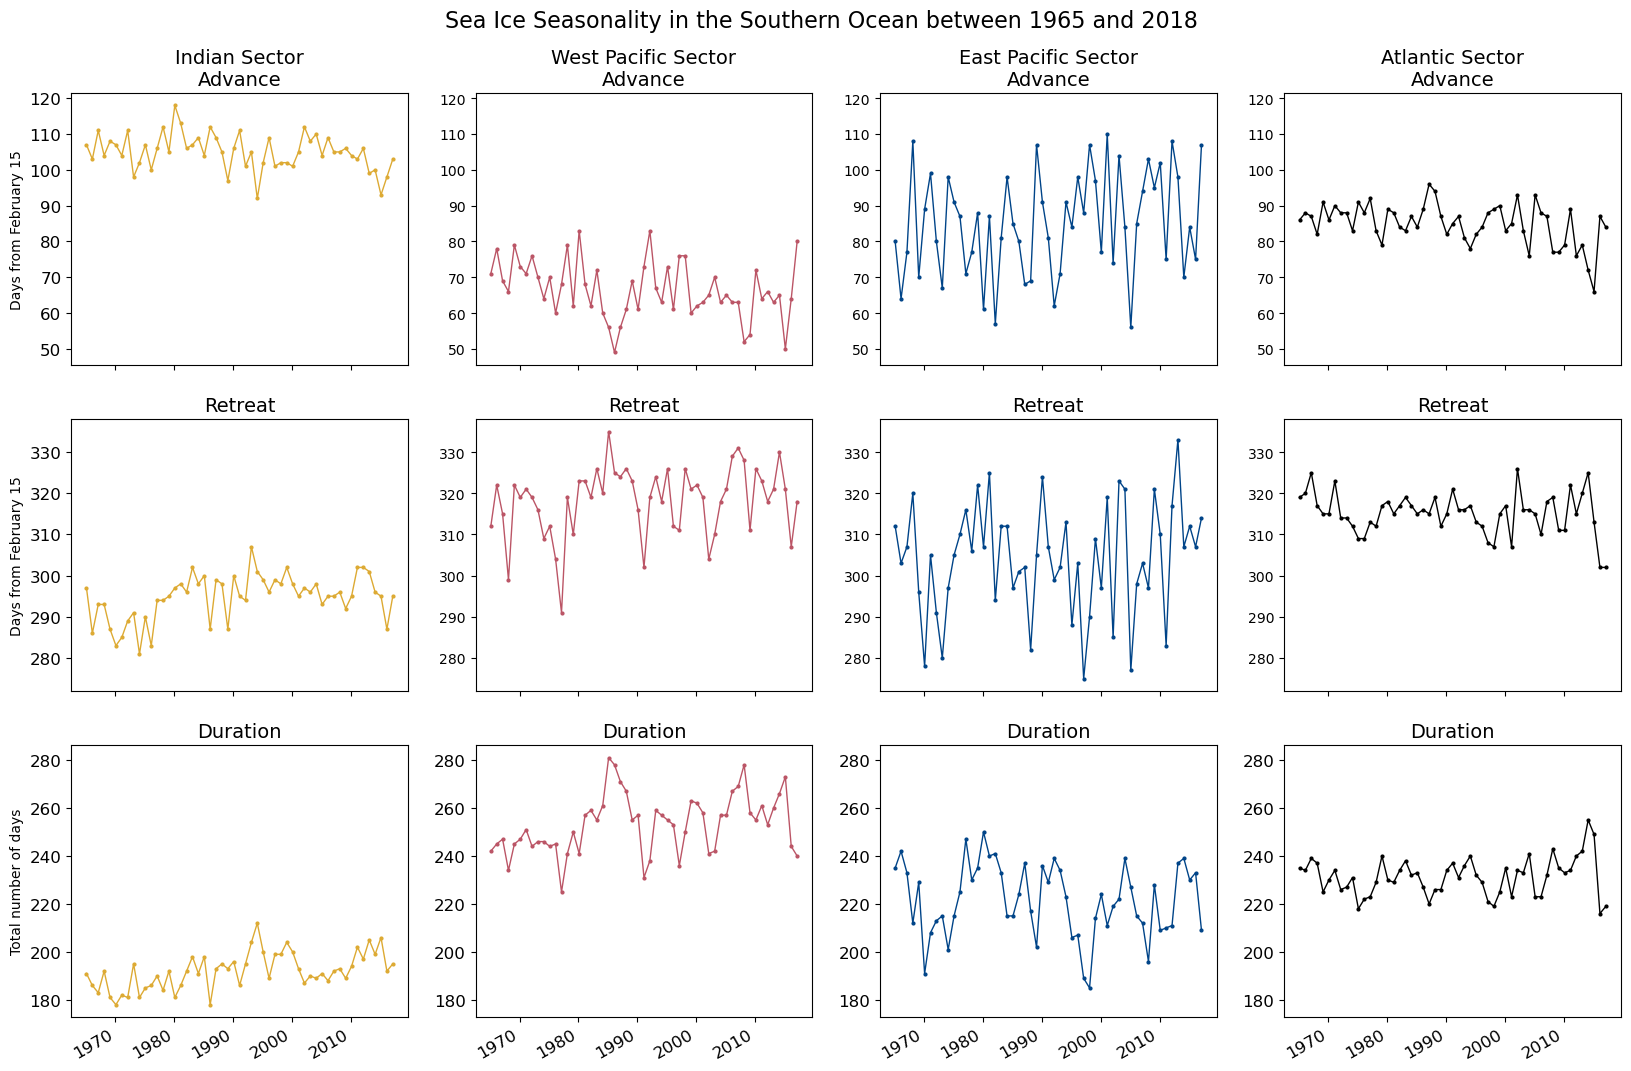

In [72]:
#Create a plot that is subdivided in four rows
fig = plt.figure(figsize = (20, 12), constrained_layout = False)
gs = gridspec.GridSpec(nrows = 3, ncols = 4)

#####Colors used for plotting are colourblind safe#####
#Plotting Indian sector - sharing x axis with Atl
Ind = fig.add_subplot(gs[0, 0])
Ind_adv.plot(linewidth = 1, marker='o', markersize = 2, color = "#DDAA33")
Ind.set_title("Indian Sector" + "\n" + "Advance", fontsize = 14)
Ind.set_ylabel('Days from February 15')
Ind.tick_params(labelsize = 12)

Ind_r = fig.add_subplot(gs[1, 0])
Ind_ret.plot(linewidth = 1, marker='o', markersize = 2, color = "#DDAA33", ax = Ind_r)
Ind_r.set_title("Retreat", fontsize = 14)
Ind_r.tick_params(labelsize = 12)
Ind_r.set_ylabel('Days from February 15')

Ind_d = fig.add_subplot(gs[2, 0])
Ind_dur.plot(linewidth = 1, marker='o', markersize = 2, color = "#DDAA33", ax = Ind_d)
Ind_d.set_title("Duration", fontsize = 14)
Ind_d.tick_params(labelsize = 12)
Ind_d.set_ylabel('Total number of days')


#####
#Plotting West Pacific sector
WP = fig.add_subplot(gs[0, 1], sharey = Ind)
WP_adv.plot(linewidth = 1, marker = 'o', markersize = 2, color = "#BB5566")
WP.set_title("West Pacific Sector" + "\n" + "Advance", fontsize = 14)

WP_r = fig.add_subplot(gs[1, 1], sharey = Ind_r)
WP_ret.plot(linewidth = 1, marker = 'o', markersize = 2, color = "#BB5566")
WP_r.set_title("Retreat", fontsize = 14)

WP_d = fig.add_subplot(gs[2, 1], sharey = Ind_d)
WP_dur.plot(linewidth = 1, marker = 'o', markersize = 2, color = "#BB5566")
WP_d.set_title("Duration", fontsize = 14)
WP_d.tick_params(labelsize = 12)


#####
#Plotting East Pacific sector - sharing x axis with Atl
EP = fig.add_subplot(gs[0, 2], sharey = Ind)
EP_adv.plot(linewidth = 1, marker='o', markersize = 2, color = "#004488")
EP.set_title("East Pacific Sector" + "\n" + "Advance", fontsize = 14)

EP_r = fig.add_subplot(gs[1, 2], sharey = Ind_r)
EP_ret.plot(linewidth = 1, marker='o', markersize = 2, color = "#004488")
EP_r.set_title("Retreat", fontsize = 14)

EP_d = fig.add_subplot(gs[2, 2], sharey = Ind_d)
EP_dur.plot(linewidth = 1, marker='o', markersize = 2, color = "#004488")
EP_d.set_title("Duration", fontsize = 14)
EP_d.tick_params(labelsize = 12)


#####
#Plotting Atlantic sector
Atl = fig.add_subplot(gs[0, 3], sharey = Ind)
Atl_adv.plot(linewidth = 1, marker = 'o', markersize = 2, color = "#000000", ax = Atl)
Atl.set_title("Atlantic Sector"+ "\n" + "Advance", fontsize = 14)

Atl_r = fig.add_subplot(gs[1, 3], sharey = Ind_r)
Atl_ret.plot(linewidth = 1, marker = 'o', markersize = 2, color = "#000000", ax = Atl_r)
Atl_r.set_title("Retreat", fontsize = 14)

Atl_d = fig.add_subplot(gs[2, 3], sharey = Ind_d)
Atl_dur.plot(linewidth = 1, marker = 'o', markersize = 2, color = "#000000", ax = Atl_d)
Atl_d.set_title("Duration", fontsize = 14)
Atl_d.tick_params(labelsize = 12)

#####
#Remove x tick labels so the plot does not look too crowded
plt.setp([a.set_xticklabels([]) for a in [Ind, Ind_r, Atl, Atl_r, WP, WP_r, EP, EP_r]]) 
plt.setp([a.set_ylabel('') for a in [Atl, Atl_d, Atl_r, WP, WP_d, WP_r, EP, EP_r, EP_d]]) 
plt.setp([a.set_xlabel('') for a in [Ind, Ind_r, Ind_d, Atl, Atl_r, Atl_d, WP, WP_r, WP_d, EP, EP_r, EP_d]])

#Add a main title to the plot
plt.suptitle('Sea Ice Seasonality in the Southern Ocean between 1965 and 2018', size = 16, y = 0.95)

folder_out = '/g/data/v45/la6889/Figures/TimeSeries/SeaIceSeasonality/PolarZones'
os.makedirs(folder_out, exist_ok = True)

#Saving the plot
plt.savefig(os.path.join(folder_out, 'MeanYearlySIS_Sectors.png'), dpi = 300)

## Plotting results
Several ways of plotting data are included in the section below. Colourblind palettes have been chosen from: [https://personal.sron.nl/~pault/#sec:qualitative].

### Seasons four panels and all areas

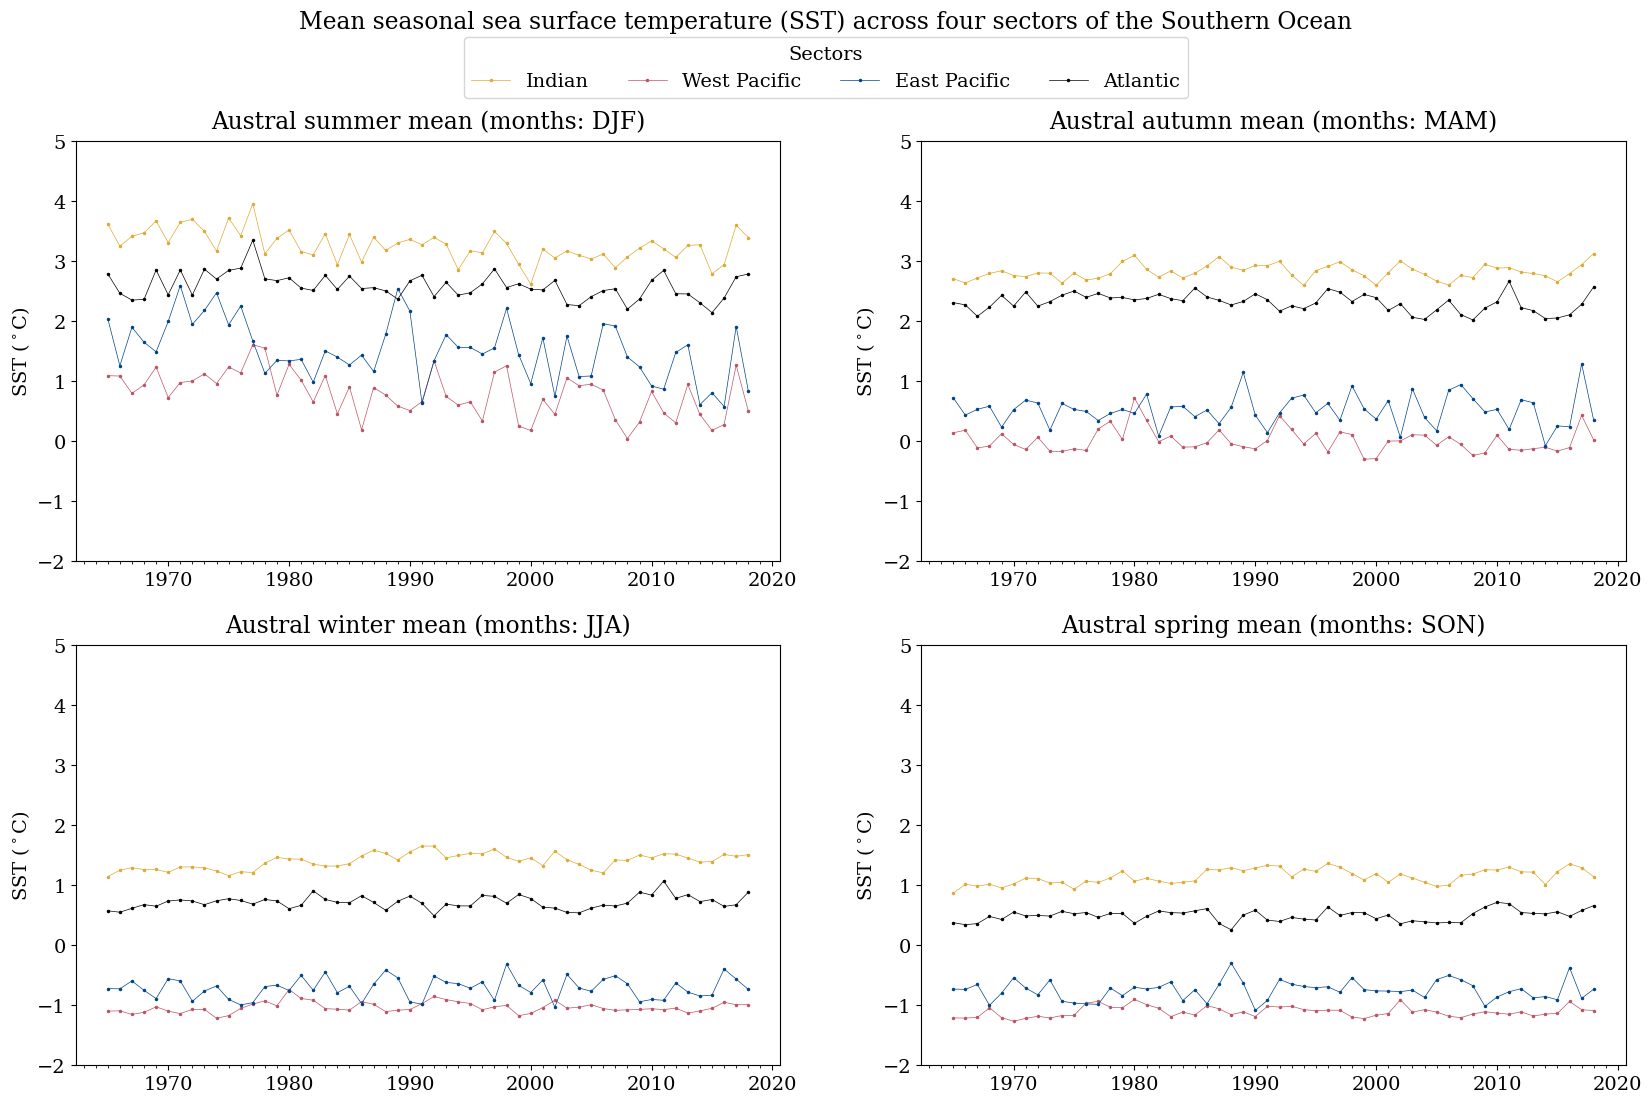

In [32]:
#Extract years included in the data arrays
years = range(int(min(comb_Ind.time.values)), int(max(comb_Ind.time.values))+1)

#Defining season names
seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 'JJA': 'Austral winter', 'SON': 'Austral spring'}

#Create composite figures
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12), constrained_layout = False)

#Change global font and font size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (0, 1, 'MAM'), (1, 0, 'JJA'), (1, 1, 'SON')]:
    axes[i, j].plot(years, comb_Ind.sel(season = season), color = '#DDAA33', label = 'Indian')
    axes[i, j].plot(years, comb_WP.sel(season = season), color = '#BB5566', label = 'West Pacific')
    axes[i, j].plot(years, comb_EP.sel(season = season), color = '#004488', label = 'East Pacific')
    axes[i, j].plot(years, comb_Atl.sel(season = season), color = '#000000', label = 'Atlantic')
    #Set title for each subplot using season dictionaries. Move the title along the y axis so it is not too far from the plot
    axes[i,j].set_title(seasonName[season] + ' mean (months: ' + season + ')', y = 1.01)
    #Change axes labels
#     axes[i,j].set_ylabel('MLD (m)')
    axes[i,j].set_ylabel('SST ($^\circ$C)')
    axes[i,j].set_xlabel('')
    axes[i,j].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    #Change y axis limits
#     plt.setp(axes[i, j].set_ylim([250, 0])) #MLD
#     plt.setp(axes[i, j].set_ylim([5200, 0])) #MLD max
    plt.setp(axes[i, j].set_ylim([-2, 5])) #SST
    #Change line width and marker type for all axes
    plt.setp(axes[i, j].lines, linewidth = 0.5, marker = 'o', markersize = 1.5)

#####
#Shared legend
#Extract legend labels and handles for one axes (as they are all the same)
handles, labels = axes[0,0].get_legend_handles_labels()
#Plot shared legend, add title, make it horizontal and change its location to the top of the figure 
fig.legend(handles, labels, title = 'Sectors', ncol = 4, loc = 'upper center', bbox_to_anchor = (0.5, 0.975))

#####
#Add title
# fig.suptitle('Mean seasonal mixed layer depth (MLD) across four sectors of the Southern Ocean', y = 0.99)
# fig.suptitle('Maximum seasonal mixed layer depth (MLD) across four sectors of the Southern Ocean', y = .99)
fig.suptitle('Mean seasonal sea surface temperature (SST) across four sectors of the Southern Ocean', y = 0.99)
    
#####
#Save figure
# plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/MLD/PolarZones/MeanSeasonSectorsMLD_FourPanels_daily.png', dpi = 300)
# plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/MLD/PolarZones/MaxSeasonSectorsMLD_FourPanels_daily.png', dpi = 300)
plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/PolarZones/MeanSeasonSectorsSST_FourPanels_daily.png', dpi = 300)

### Plotting seasonal time series for each sector in a different panel

ValueError: operands could not be broadcast together with shapes (54,) (12,) 

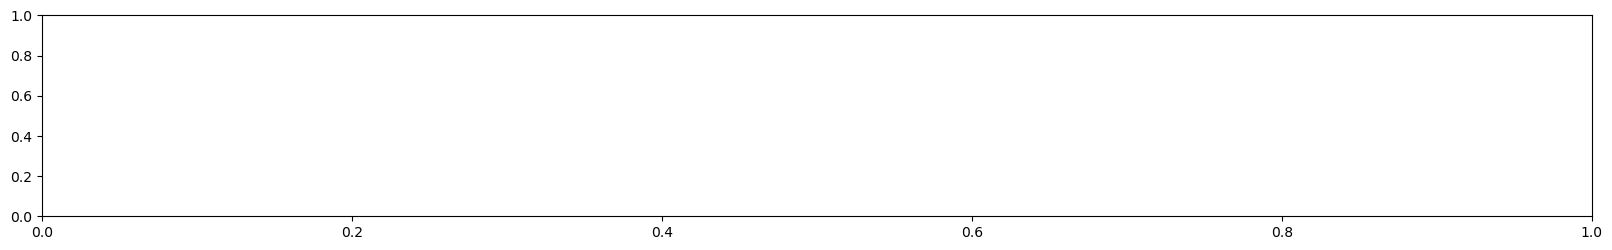

In [19]:
#Create a plot that is subdivided in four rows
fig = plt.figure(figsize = (20, 12), constrained_layout = False)
gs = gridspec.GridSpec(nrows = 4, ncols = 1)

#Create labels for x axis
x_labels = [''] 
#MLD season
# [x_labels.append(i) for i in comb_Atl.time.values]

for i in comb_Atl.season.values:
    x_labels.append(i)

#####Colors used for plotting are colourblind safe#####
#Plotting Atlantic sector
Atl = fig.add_subplot(gs[3, 0])
# Atl.plot((comb_Atl.time.values + '_' + comb_Atl.season.values), comb_Atl.values, linewidth=0.5, marker='o',markersize=1.5, color = "#000000")#MLD season
Atl.plot((comb_Atl.season.values + '_' + comb_Atl.month.values), comb_Atl.values, linewidth=0.5, marker='o',markersize=1.5, color = "#000000")
# comb_Atl.plot(linewidth=0.5, marker='o',markersize=1.5, ax = Atl, color = "#000000")
Atl.tick_params(axis = 'x', which = "major", length = 4)
[l.set_visible(False) for (i,l) in enumerate(Atl.xaxis.get_ticklabels()) if (i == 0 or i % 4 != 0)]
plt.xticks(rotation = 90)
Atl.tick_params(labelsize=12)

#Plotting Indian sector - sharing x axis with Atl
Ind = fig.add_subplot(gs[0, 0], sharex = Atl)
Ind.plot((comb_Ind.time.values + '_' + comb_Ind.season.values), comb_Ind.values, linewidth=0.5, marker='o', markersize=1.5, color = "#DDAA33")
# comb_Ind.plot(linewidth=0.5, marker='o', markersize=1.5, ax = Ind, color = "#DDAA33")
Ind.set_title("Indian Sector")

#Plotting West Pacific sector - sharing x axis with Atl
WP = fig.add_subplot(gs[1, 0], sharex = Atl)
WP.plot((comb_WP.time.values + '_' + comb_WP.season.values), comb_WP.values, linewidth=0.5, marker='o',markersize=1.5, color = "#BB5566")
WP.set_title("West Pacific Sector")

#Plotting East Pacific sector - sharing x axis with Atl
EP = fig.add_subplot(gs[2, 0], sharex = Atl)
EP.plot((comb_EP.time.values + '_' + comb_EP.season.values), comb_EP.values, linewidth=0.5, marker='o',markersize=1.5, color = "#004488")
EP.set_title("East Pacific Sector")

#Remove x tick labels so the plot does not look too crowded
plt.setp([a.set_xlabel("") for a in [Ind, WP, EP, Atl]])
# plt.setp([a.set_ylabel('MLD (m)') for a in [Ind, WP, EP, Atl]]) #MLD
plt.setp([a.set_ylabel('SST ($^\circ$C)') for a in [Ind, WP, EP, Atl]]) #SST
plt.setp([a.get_xticklabels() for a in [Ind, WP, EP]], visible = False)
plt.setp([a.xaxis.set_ticklabels(x_labels) for a in [Ind, WP, EP, Atl]])

#Set y limits to be the same for all plots - So they can be more easily compared
# plt.setp([a.set_ylim([-2.5, 5]) for a in [Ind, WP, EP, Atl]]) #SST
plt.setp([a.set_ylim([250, 0]) for a in [Ind, WP, EP, Atl]]) #MLD


#Add a main title to the plot
# plt.suptitle('Mean Seasonal Mixed Layer Depth (MLD) in the Southern Ocean between 1965 and 2018', size = 16, y = 0.93)
plt.suptitle('Mean Monthly Sea Surface Temperature (SST) in the Southern Ocean between 1965 and 2018', size = 16, y = 0.93)

#Saving the plot
# plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/MLD/PolarZones/MeanSeasonalMLD_SectorsFourPanels.png', dpi = 300)
plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/PolarZones/MeanSeasonalSST_SectorsFourPanels.png', dpi = 300)

### Plotting monthly time series for each sector in a different panel

In [9]:
Atl_s = comb_Atl.to_series()
Ind_s = comb_Ind.to_series()
WP_s = comb_WP.to_series()
EP_s = comb_EP.to_series()

In [10]:
Atl_s.to_csv('Atl_MLD.csv')
Ind_s.to_csv('Ind_MLD.csv')
WP_s.to_csv('WP_MLD.csv')
EP_s.to_csv('EP_MLD.csv')

In [23]:
#Correcting season to years and months from digits to abbreviations
zsf.corrYears(comb_Atl)
zsf.corrYears(comb_EP)
zsf.corrYears(comb_Ind)
zsf.corrYears(comb_WP)

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  font

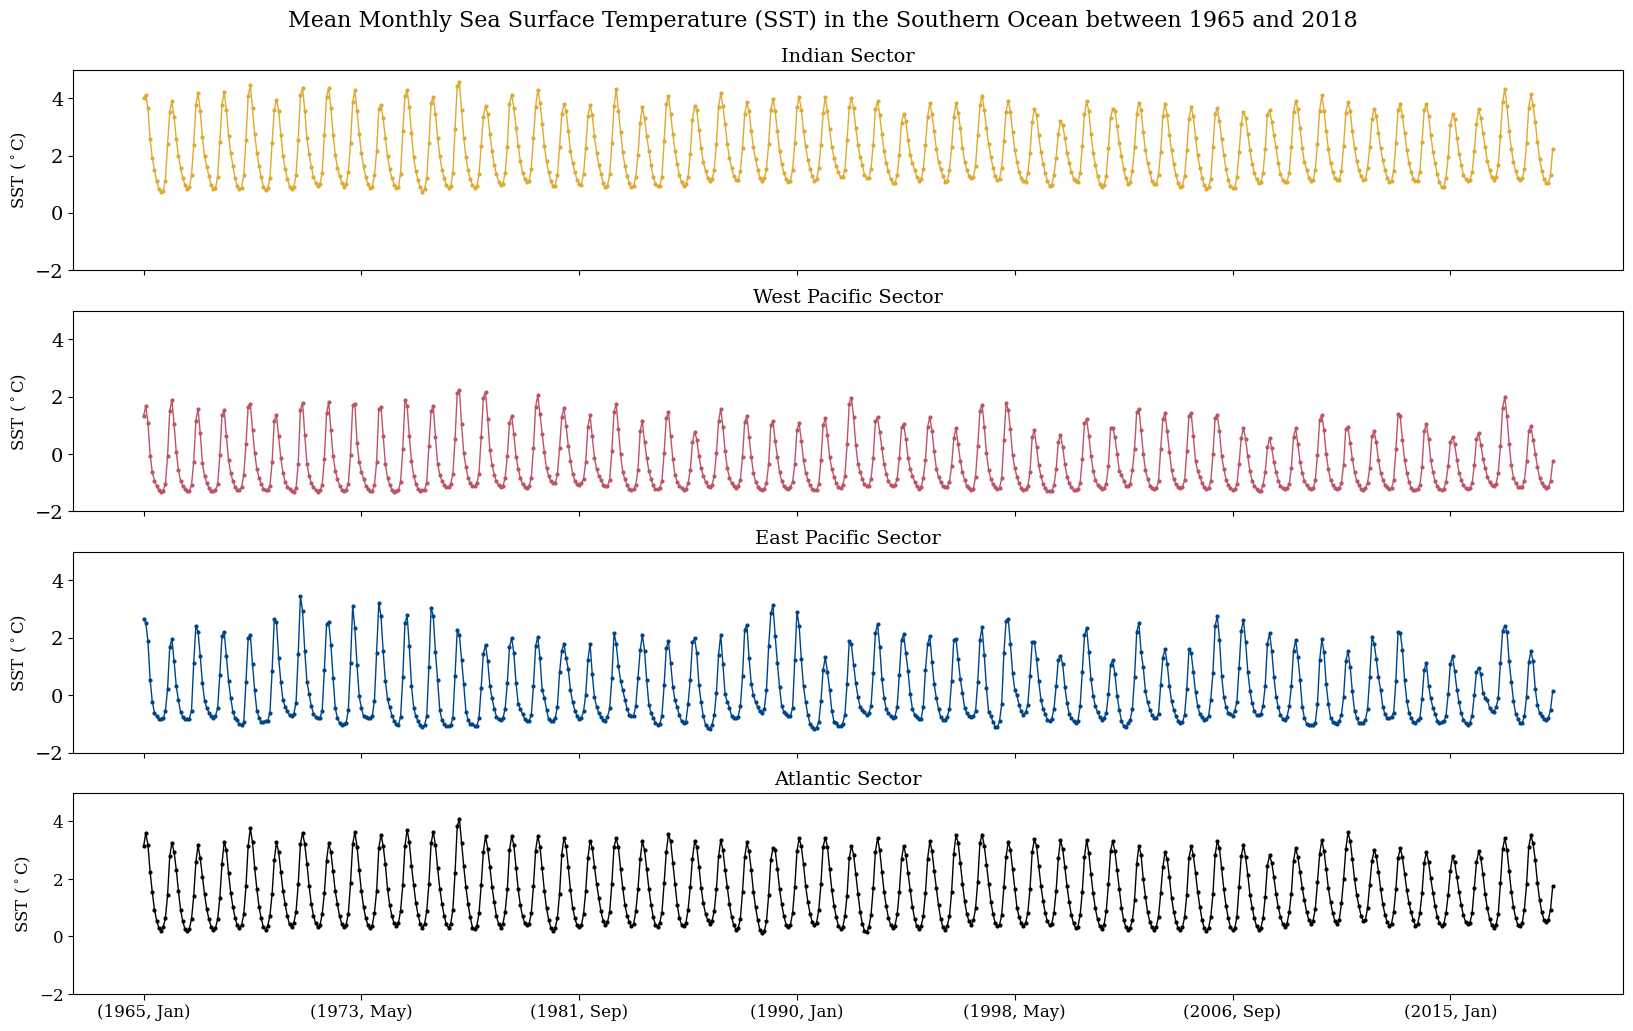

In [27]:
#Changing xarrays to series before plotting
Atl_s = comb_Atl.to_series()
Ind_s = comb_Ind.to_series()
WP_s = comb_WP.to_series()
EP_s = comb_EP.to_series()

#Create a plot that is subdivided in four rows
fig = plt.figure(figsize = (20, 12), constrained_layout = False)
gs = gridspec.GridSpec(nrows = 4, ncols = 1)

#####Colors used for plotting are colourblind safe#####
#Plotting Atlantic sector
Atl = fig.add_subplot(gs[3, 0])
Atl_s.plot(linewidth = 1, marker = 'o', markersize = 2, color = "#000000", ax = Atl)
Atl.tick_params(axis = 'x', which = "major", length = 4)
Atl.set_title("Atlantic Sector", fontsize = 14)
Atl.tick_params(labelsize = 12)

#Plotting Indian sector - sharing x axis with Atl
Ind = fig.add_subplot(gs[0, 0], sharex = Atl)
Ind_s.plot(linewidth = 1, marker='o', markersize = 2, color = "#DDAA33")
Ind.set_title("Indian Sector", fontsize = 14)

#Plotting West Pacific sector - sharing x axis with Atl
WP = fig.add_subplot(gs[1, 0], sharex = Atl)
WP_s.plot(linewidth = 1, marker = 'o', markersize = 2, color = "#BB5566")
WP.set_title("West Pacific Sector", fontsize = 14)

#Plotting East Pacific sector - sharing x axis with Atl
EP = fig.add_subplot(gs[2, 0], sharex = Atl)
EP_s.plot(linewidth = 1, marker='o', markersize = 2, color = "#004488")
EP.set_title("East Pacific Sector", fontsize = 14)

#Remove x tick labels so the plot does not look too crowded
plt.setp([a.set_xlabel("") for a in [Ind, WP, EP, Atl]])
# plt.setp([a.set_ylabel('MLD (m)') for a in [Ind, WP, EP, Atl]])
plt.setp([a.set_ylabel('SST ($^\circ$C)', fontsize = 12) for a in [Ind, WP, EP, Atl]])

#Set y limits to be the same for all plots - So they can be more easily compared
plt.setp([a.set_ylim([-2, 5]) for a in [Ind, WP, EP, Atl]]) #SST
# plt.setp([a.set_ylim([375, 0]) for a in [Ind, WP, EP, Atl]]) #MLD


#Add a main title to the plot
# plt.suptitle('Mean Seasonal Mixed Layer Depth (MLD) in the Southern Ocean between 1965 and 2018', size = 16, y = 0.93)
plt.suptitle('Mean Monthly Sea Surface Temperature (SST) in the Southern Ocean between 1965 and 2018', size = 16, y = 0.93)

#Saving the plot
# plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/MLD/PolarZones/MeanMonthlyMLD_SectorsFourPanels.png', dpi = 300)
plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/PolarZones/MeanMonthlySST_SectorsFourPanels.png', dpi = 300)

### Plotting months three panels

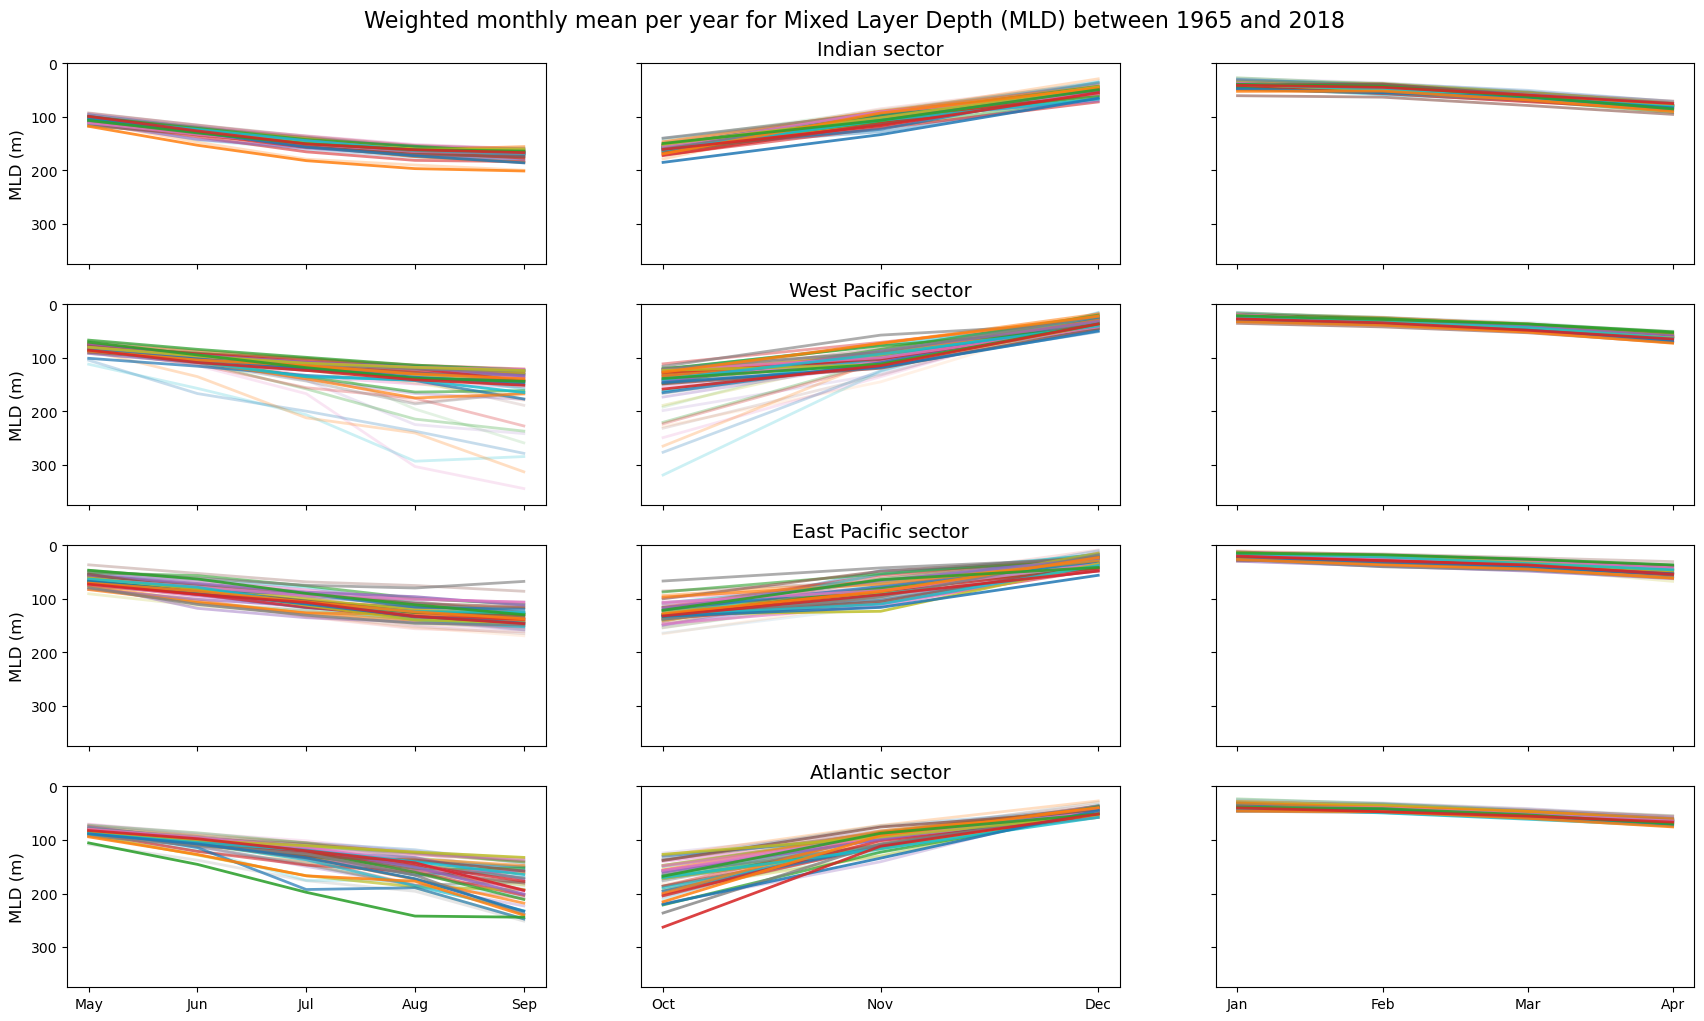

In [28]:
# comb_Ind, comb_WP, comb_EP, comb_Atl
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (21, 12))
Years = comb_Ind.season.values

Months1 = [calendar.month_abbr[m] for m in range(5, 10)]
Ind_May = comb_Ind.loc[:, Months1]

alpha = np.arange(0.1, 1., 0.03)
alpha = np.repeat(alpha, 2)

#########
#Indian sector
for i in range(0, len(Years)):
# #Plot line on the same figures - Months variable is used as X axis
    axes[0,0].plot(Months1, Ind_May.values[i],
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])

Months2 = [calendar.month_abbr[m] for m in range(10, 13)]
# y = xr.concat([comb_Ind.sel(month = slice(10, 12)), comb_Ind.sel(month = slice(1, 4))], dim="month")
Ind_Oct = comb_Ind.loc[:, Months2]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[0,1].plot(Months2, Ind_Oct.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])
axes[0,1].set_title('Indian sector', fontsize = 14)

Months3 = [calendar.month_abbr[m] for m in range(1, 5)]
Ind_Jan = comb_Ind.loc[:, Months3]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[0,2].plot(Months3, Ind_Jan.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])


#########
#West Pacific sector
WP_May = comb_WP.loc[:, Months1]
for i in range(0, len(Years)):
# #Plot line on the same figures - Months variable is used as X axis
    axes[1,0].plot(Months1, WP_May.values[i],
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])

WP_Oct = comb_WP.loc[:, Months2]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[1,1].plot(Months2, WP_Oct.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])
axes[1,1].set_title('West Pacific sector', fontsize = 14)

WP_Jan = comb_WP.loc[:, Months3]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[1,2].plot(Months3, WP_Jan.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])


#########
#East Pacific sector
EP_May = comb_EP.loc[:, Months1]
for i in range(0, len(Years)):
# #Plot line on the same figures - Months variable is used as X axis
    axes[2,0].plot(Months1, EP_May.values[i],
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])

EP_Oct = comb_EP.loc[:, Months2]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[2,1].plot(Months2, EP_Oct.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])
axes[2,1].set_title('East Pacific sector', fontsize = 14)

EP_Jan = comb_EP.loc[:, Months3]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[2,2].plot(Months3, EP_Jan.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])


#########
#Atlantic sector
Atl_May = comb_Atl.loc[:, Months1]
for i in range(0, len(Years)):
# #Plot line on the same figures - Months variable is used as X axis
    axes[3,0].plot(Months1, Atl_May.values[i],
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])

Atl_Oct = comb_Atl.loc[:, Months2]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[3,1].plot(Months2, Atl_Oct.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])
axes[3,1].set_title('Atlantic sector', fontsize = 14)

Atl_Jan = comb_Atl.loc[:, Months3]
for i in range(0, len(Years)):
#Plot line on the same figures - Months variable is used as X axis
    axes[3,2].plot(Months3, Atl_Jan.values[i], 
                #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
                label = Years[i], 
                #Changing line width and line style
                linewidth = 2, alpha = alpha[i])

for ax in axes[0:3,:].flat:
    ax.set_xticklabels([])
for ax in axes[:,1:].flat:
    ax.set_yticklabels([])
for ax in axes[:, 0].flat:
#     ax.set_ylabel('SST ($^\circ$C)', fontsize = 12)
    ax.set_ylabel('MLD (m)', fontsize = 12)
for ax in axes.flat:
    ax.set_ylim(375, 0) #MLD
#     ax.set_ylim(-2, 5) #SST

# handles, labels = axes[0,0].get_legend_handles_labels()
#Plot shared legend, add title, make it horizontal and change its location to the top of the figure 
# fig.legend(handles, labels, title = 'Sectors', ncol = 10, loc = 'upper center', bbox_to_anchor = (0.5, 1.19))

plt.suptitle('Weighted monthly mean per year for Mixed Layer Depth (MLD) between 1965 and 2018', y = 0.925, fontsize = 16)
# plt.suptitle('Weighted monthly mean per year for Sea Surface Temperature (SST) between 1965 and 2018', y = 0.925)

plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/MLD/PolarZones/MeanSectorsMLD_ThreePanels_Monthly.png', dpi = 300)
# plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/PolarZones/MeanSectorsSST_ThreePanels_Monthly.png', dpi = 300)

**Plotting all sectors in one panel**

In [ ]:
#Intitialise figure
fig, ax = plt.subplots(figsize = (25, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Start plotting each sector
weightedIndian.plot(ax = ax, linewidth=0.5, marker='o',markersize=1.5, color = '#DDAA33', label = "Indian")
weightedWP.plot(ax = ax, linewidth=0.5, marker='o',markersize=1.5, color = '#BB5566', label = "West Pacific")
weightedEP.plot(ax = ax, linewidth=0.5, marker='o',markersize=1.5, color = '#004488', label = "East Pacific")
weightedAtlantic.plot(ax = ax, linewidth=0.5, marker='o',markersize=1.5, color = '#000000', label = "Atlantic")

#Add legend to graph - Add a title, change number of columns being shown, change location to the upper center, and use a med size font
ax.legend(title = "Sectors", ncol = 4, bbox_to_anchor = (0.5, 1.05), loc = 'upper center', fontsize = 'medium')
#Note for `bbox_to_anchor`, (0, 0) refers to the bottom left corner of the graph, and (1, 1) refers to the top right corner of the figure

#Remove x label
ax.set_xlabel("")
#Change y label
ax.set_ylabel("SST ($^\circ$C)")

#Add a title to the graph
ax.set_title('Mean Monthly Sea Surface Temperature (SST) in the Southern Ocean between 1965 and 2018', size = 16, y = 1.05)

#Saving the plot
plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/ContinentalShelf/MeanMonthlySST_AllSectorOnePanels.png', dpi = 350)

### Plotting monthly means per sector with subplots for min and max monthly values
Defining functions that calculate monthly mean, min and max values per decade and per year.

In [ ]:
def plot_decade(xarray, s_year, ax, stat = 'mean', **kwargs):
    '''
    Inputs:
    array - Data array containing variable from which decadal monthly means will be calculated
    s_year - The year when the decade starts
    ax - Plot axis where means will be plotted
    stat - It defines what calculations should be performed on the array. Accepts strings: mean, min and max. If no input is given is set to mean.
    **Optional (kwargs):
    *Note that both kwargs need to be provided if y axis limits are to be changed*
    minVal - changes the minimum value shown in the y axis
    maxVal - minVal - changes the maximum value shown in the y axis
    
    Output:
    Figure with a line showing the decadal monthly means in thick coloured lines
    '''
    
    #Slice the array to cover one decade of data starting from s_year
    array_dec = xarray.sel(time = slice(str(s_year), str(s_year + 9)))
        
    #Checking the stat parameter to perform the appropriate calculation.
    #Monthly means
    if stat == 'mean':
        monthly_mean_dec = array_dec.groupby('time.month').mean()
        ls = "-"
    #Minimum monthly values
    elif stat == 'min':
        monthly_mean_dec = array_dec.groupby('time.month').min()
        ls = ":"
    #Maximum monthly values
    elif stat == 'max':
        #Calculate monthly means from sliced array
        monthly_mean_dec = array_dec.groupby('time.month').max()
        ls = "--"
        
    #Create a vector with the month abbreviations in English to label x axis
    Months = [calendar.month_abbr[m] for m in range(1, 13)]
    
    #Extract maximum year value in the data array (used for labelling)
    MaxY = max(array_dec.indexes['time'].to_datetimeindex().year)
    
    #Plot line on the same figures - Months variable is used as X axis
    ax.plot(Months, monthly_mean_dec.values, 
            #Label assigned to each line will show the minimum and maximum year included in the monthly calculations
            label = f'{s_year}-{MaxY}', 
            #Changing line width and line style
            linewidth = 2, linestyle = ls)
    
    #If minVal and maxVal kwargs are provided, then change the limit of the y axis
    if 'minVal' in kwargs.keys() and 'maxVal' in kwargs.keys():
        ax.set_ylim([kwargs.get('minVal'), kwargs.get('maxVal')])

**Creating composite graph**

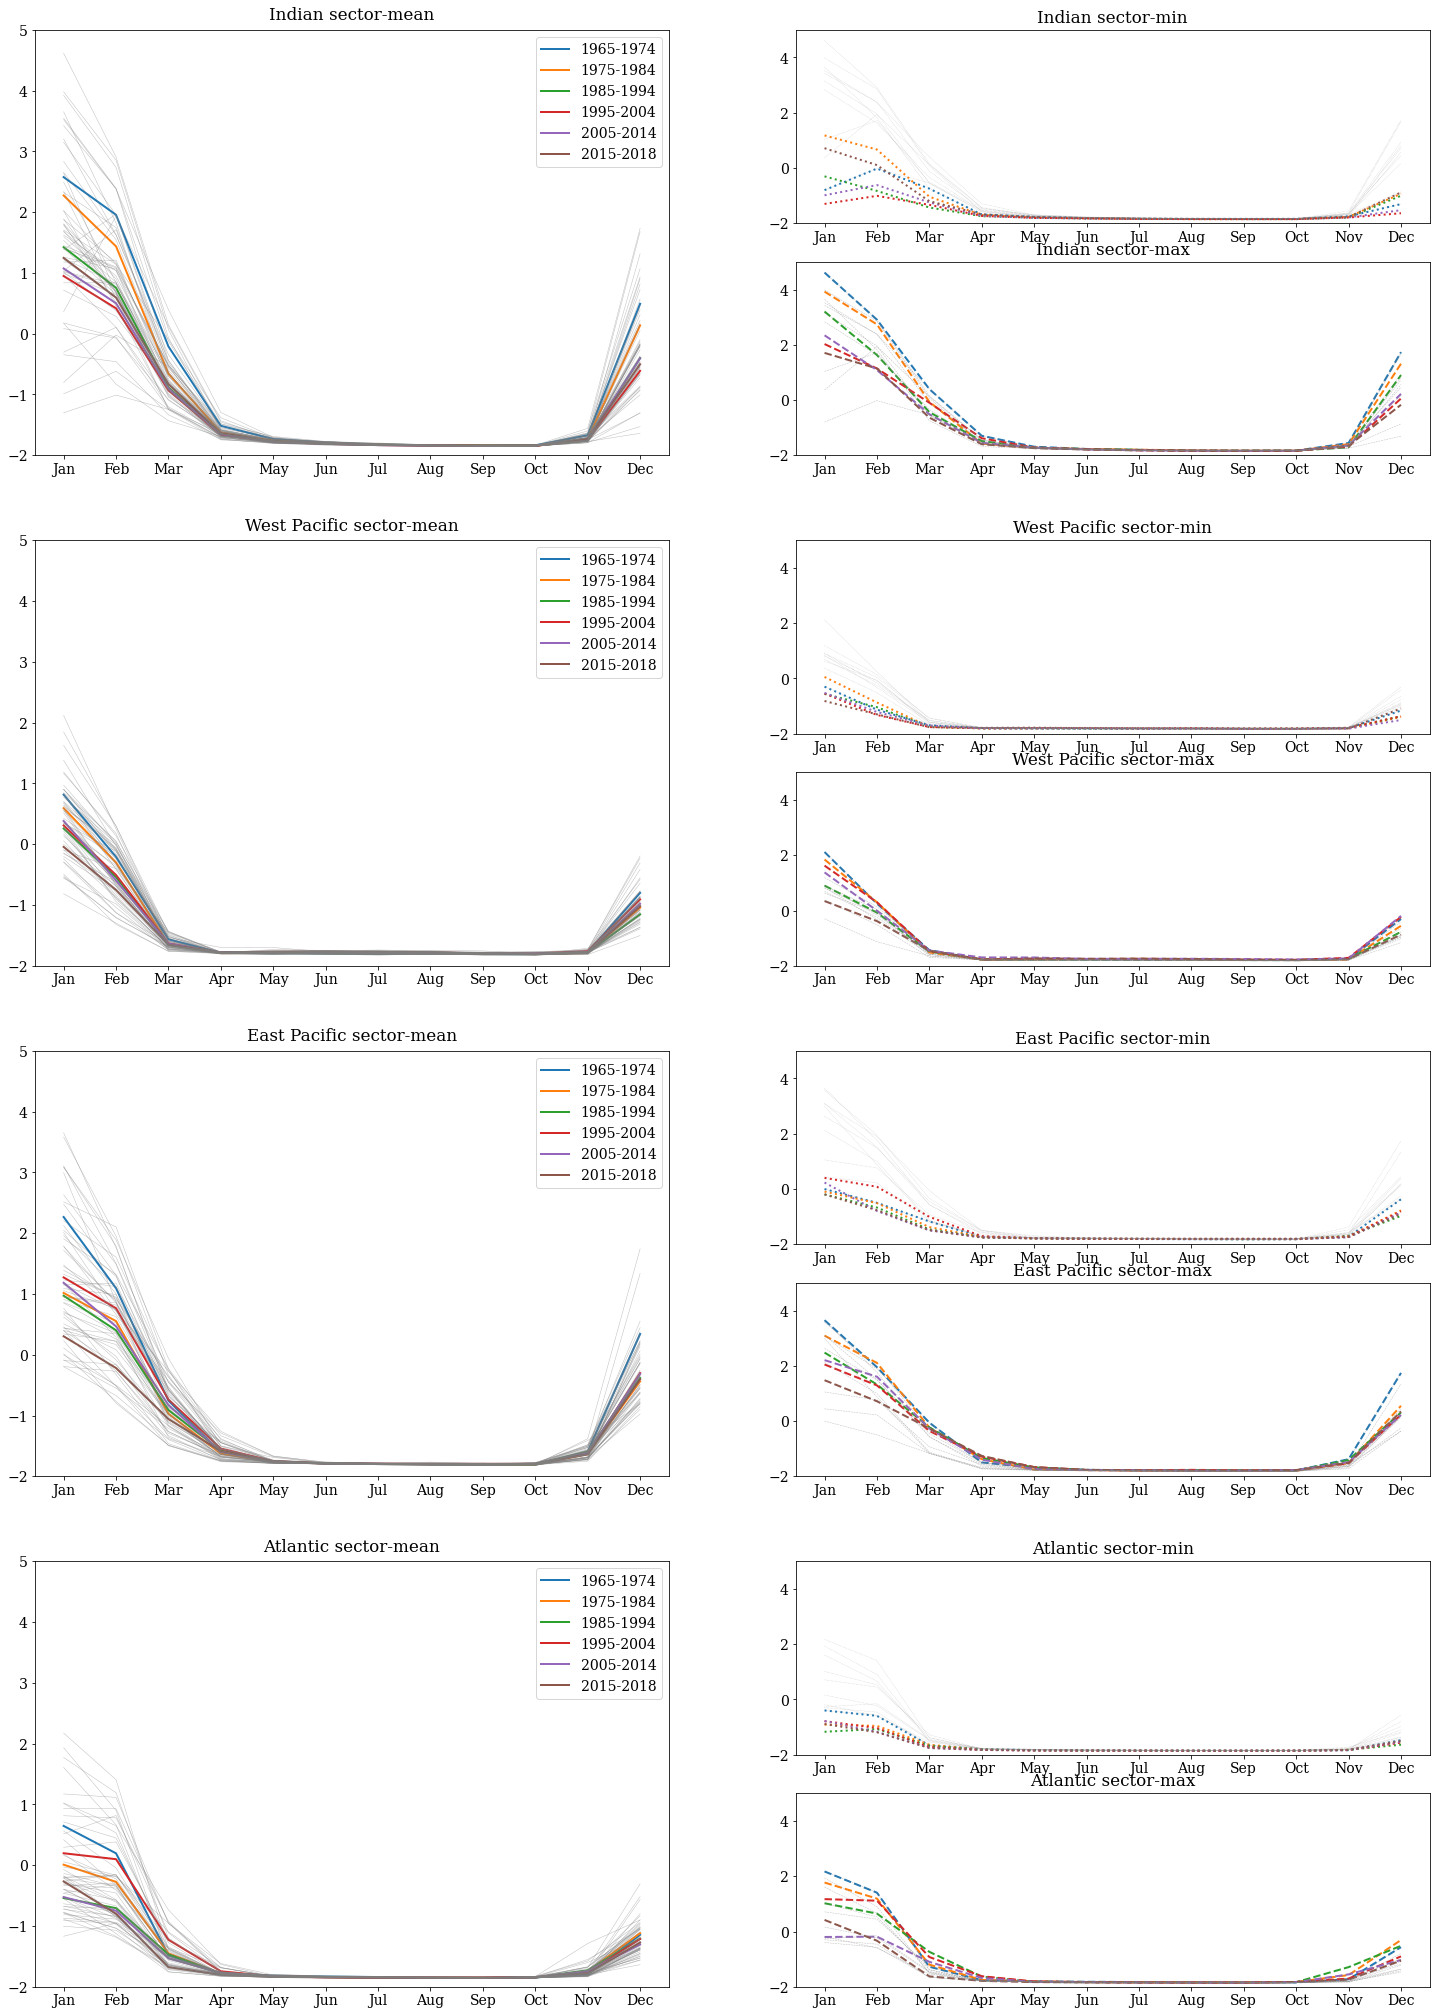

In [19]:
#Set minimum and maximum values to be used for y axis limits
minVal = -2
maxVal = 5

#Initialise graph
fig = plt.figure(figsize = (25, 36))
#Create a grid to plot all graphs together
gs = gridspec.GridSpec(nrows = 4, ncols = 2)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#####
#Indian sector
#Mean
meanV = fig.add_subplot(gs[0, 0])
#Apply the plot_decade function for the entire time period covered by ACCESS-OM2-01
for dec in range(1965, 2019, 10):
    plot_decade(weightedIndian, dec, meanV, stat = 'mean', minVal = minVal, maxVal = maxVal)
# #Apply the plot_year function for the entire time period covered by ACCESS-OM2-01
for year in range(1965, 2019):
    plot_year(weightedIndian, year, meanV)
meanV.set_title('Indian sector-mean', y = 1.01)
meanV.legend()

#Minimum
MinMax = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gs[0, 1])
minV = fig.add_subplot(MinMax[0])
for dec in range(1965, 2019, 10):
    plot_decade(weightedIndian, dec, minV, stat = 'min', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedIndian, year, minV, stat = 'min')
minV.set_title('Indian sector-min', y = 1.01)

#Maximum
maxV = fig.add_subplot(MinMax[1])
for dec in range(1965, 2019, 10):
    plot_decade(weightedIndian, dec, maxV, stat = 'max', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedIndian, year, maxV, stat = 'max')
maxV.set_title('Indian sector-max', y = 1.01)


#####
#West Pacific sector
#Mean
meanWP = fig.add_subplot(gs[1, 0])
#Apply the plot_decade function for the entire time period covered by ACCESS-OM2-01
for dec in range(1965, 2019, 10):
    plot_decade(weightedWP, dec, meanWP, stat = 'mean', minVal = minVal, maxVal = maxVal)
# #Apply the plot_year function for the entire time period covered by ACCESS-OM2-01
for year in range(1965, 2019):
    plot_year(weightedWP, year, meanWP)
meanWP.set_title('West Pacific sector-mean', y = 1.01)
meanWP.legend()

#Minimum
MinMaxWP = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gs[1, 1])
minWP = fig.add_subplot(MinMaxWP[0])
for dec in range(1965, 2019, 10):
    plot_decade(weightedWP, dec, minWP, stat = 'min', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedWP, year, minWP, stat = 'min')
minWP.set_title('West Pacific sector-min', y = 1.01)

#Maximum
maxWP = fig.add_subplot(MinMaxWP[1])
for dec in range(1965, 2019, 10):
    plot_decade(weightedWP, dec, maxWP, stat = 'max', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedWP, year, maxWP, stat = 'max')
maxWP.set_title('West Pacific sector-max', y = 1.01)


#####
#East Pacific sector
#Mean
meanEP = fig.add_subplot(gs[2, 0])
#Apply the plot_decade function for the entire time period covered by ACCESS-OM2-01
for dec in range(1965, 2019, 10):
    plot_decade(weightedEP, dec, meanEP, stat = 'mean', minVal = minVal, maxVal = maxVal)
# #Apply the plot_year function for the entire time period covered by ACCESS-OM2-01
for year in range(1965, 2019):
    plot_year(weightedEP, year, meanEP)
meanEP.set_title('East Pacific sector-mean', y = 1.01)
meanEP.legend()

#Minimum
MinMaxEP = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gs[2, 1])
minEP = fig.add_subplot(MinMaxEP[0])
for dec in range(1965, 2019, 10):
    plot_decade(weightedEP, dec, minEP, stat = 'min', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedEP, year, minEP, stat = 'min')
minEP.set_title('East Pacific sector-min', y = 1.01)

#Maximum
maxEP = fig.add_subplot(MinMaxEP[1])
for dec in range(1965, 2019, 10):
    plot_decade(weightedEP, dec, maxEP, stat = 'max', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedEP, year, maxEP, stat = 'max')
maxEP.set_title('East Pacific sector-max', y = 1.01)


#####
#Atlantic sector
meanA = fig.add_subplot(gs[3, 0])
#Apply the plot_decade function for the entire time period covered by ACCESS-OM2-01
for dec in range(1965, 2019, 10):
    plot_decade(weightedAtlantic, dec, meanA, stat = 'mean', minVal = minVal, maxVal = maxVal)
# #Apply the plot_year function for the entire time period covered by ACCESS-OM2-01
for year in range(1965, 2019):
    plot_year(weightedAtlantic, year, meanA)
meanA.set_title('Atlantic sector-mean', y = 1.01)
meanA.legend()

#Minimum 
minMaxA = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gs[3, 1])
minA = fig.add_subplot(minMaxA[0])
for dec in range(1965, 2019, 10):
    plot_decade(weightedAtlantic, dec, minA, stat = 'min', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedAtlantic, year, minA, stat = 'min')
minA.set_title('Atlantic sector-min', y = 1.01)

#Maximum
maxA = fig.add_subplot(minMaxA[1])
for dec in range(1965, 2019, 10):
    plot_decade(weightedAtlantic, dec, maxA, stat = 'max', minVal = minVal, maxVal = maxVal)
for year in range(1965, 1975):
    plot_year(weightedAtlantic, year, maxA, stat = 'max')
maxA.set_title('Atlantic sector-max', y = 1.01)

#####
#Saving composite figure
plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/ContinentalShelf/MeanMinMaxMonthlySST_AllSectorFourPanels.png', dpi = 350)

### Plotting monthly means per sector with standard deviation error bars
Defining function to calculate decadal mean and standard deviation for every month

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  font

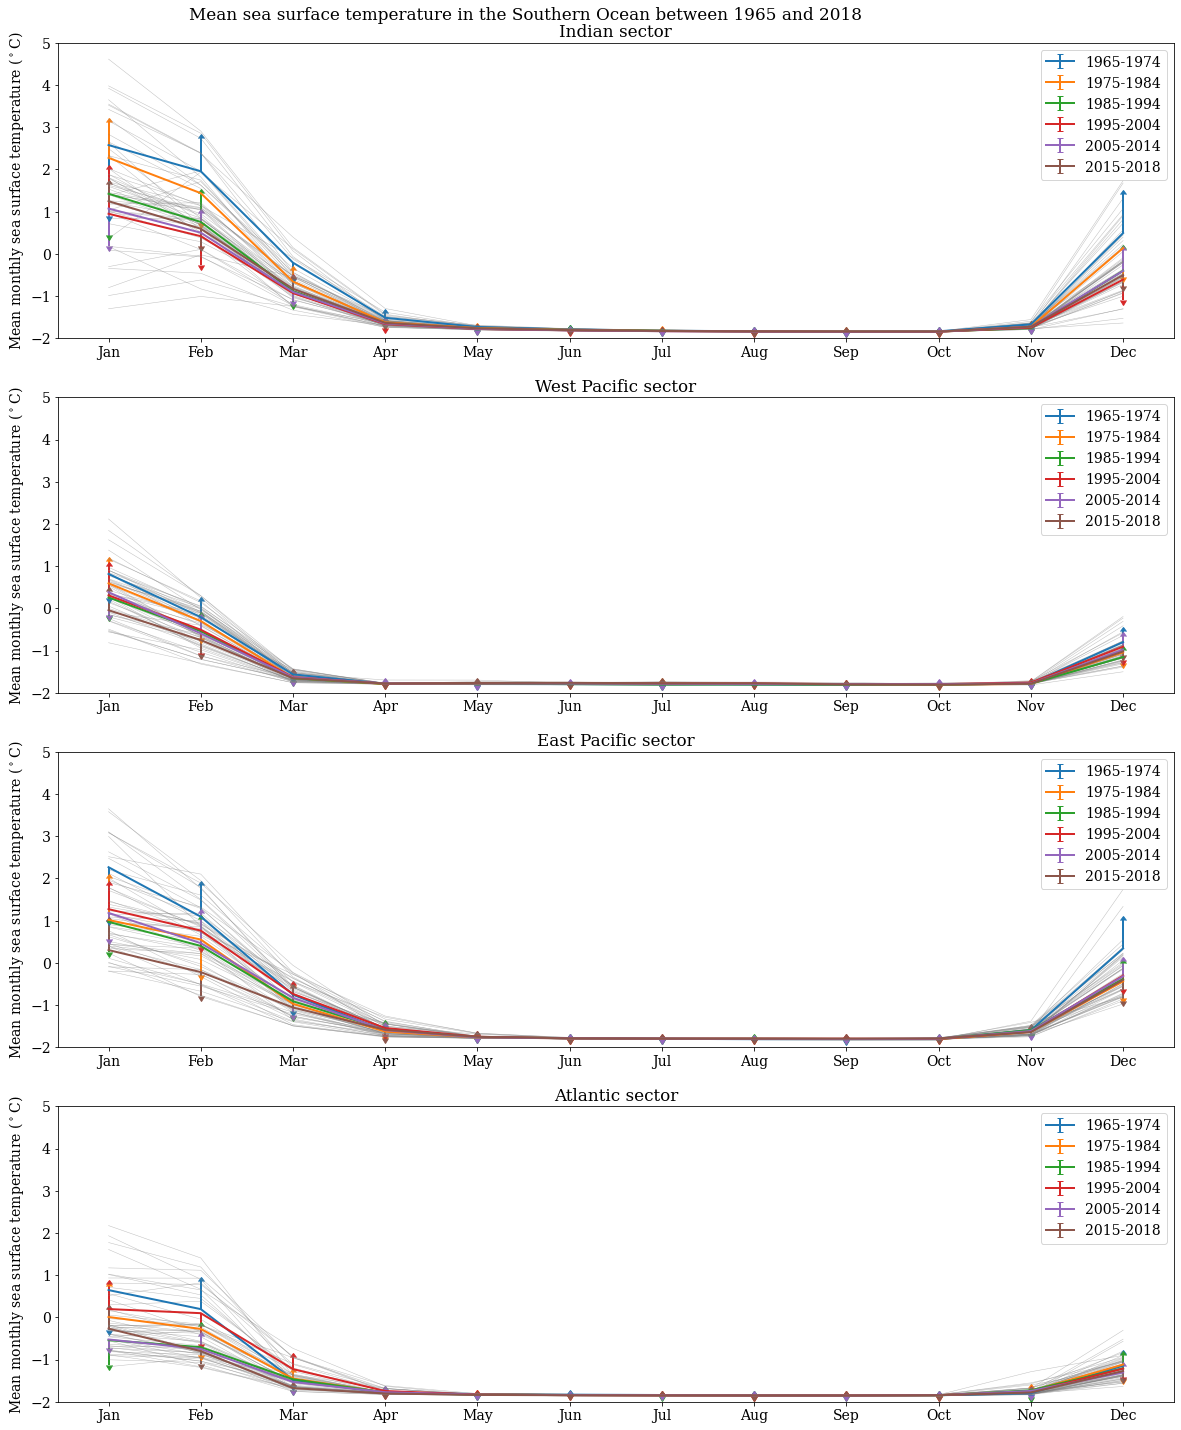

In [22]:
#Set minimum and maximum values to be used for y axis limits
minVal = -2
maxVal = 5

#Initialise graph
fig = plt.figure(figsize = (20, 25))
#Create a grid to plot all graphs together
gs = gridspec.GridSpec(nrows = 4, ncols = 1)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Defining decades to be included in the plot
decades = range(1965, 2019, 10)

#####
#Indian sector
#Apply the plot_decade function for the entire time period covered by ACCESS-OM2-01
Ind = fig.add_subplot(gs[0])
for i in range(0, len(decades)):
    plot_decadeMeanSD(weightedIndian, decades[i], Ind, stat = 'mean', minVal = minVal, maxVal = maxVal, counter = i)
#Apply the plot_year function for the entire time period covered by ACCESS-OM2-01
for year in range(1965, 2019):
    plot_year(weightedIndian, year, Ind)
Ind.set_title('Indian sector')
# Ind.set_ylabel('Mean monthly sea surface temperature ($^\circ$C)')
# Ind.legend()


#####
#West Pacific sector
WP = fig.add_subplot(gs[1])
for i in range(0, len(decades)):
    plot_decadeMeanSD(weightedWP, decades[i], WP, minVal = minVal, maxVal = maxVal, counter = i)
for year in range(1965, 2019):
    plot_year(weightedWP, year, WP)
WP.set_title('West Pacific sector')


#####
#East Pacific sector
EP = fig.add_subplot(gs[2])
for i in range(0, len(decades)):
    plot_decadeMeanSD(weightedEP, decades[i], EP, minVal = minVal, maxVal = maxVal, counter = i)
for year in range(1965, 2019):
    plot_year(weightedEP, year, EP)
EP.set_title('East Pacific sector')


#####
#Atlantic sector
Atl = fig.add_subplot(gs[3])
for i in range(0, len(decades)):
    plot_decadeMeanSD(weightedAtlantic, decades[i], Atl, minVal = minVal, maxVal = maxVal, counter = i)
for year in range(1965, 2019):
    plot_year(weightedAtlantic, year, Atl)
Atl.set_title('Atlantic sector')

#Remove x tick labels so the plot does not look too crowded
plt.setp([a.set_ylabel('Mean monthly sea surface temperature ($^\circ$C)') for a in [Ind, WP, EP, Atl]])
plt.setp([a.legend() for a in [Ind, WP, EP, Atl]])
    
#Set title for composite figure. Move the title along the y axis so it is not too far from 
fig.suptitle('Mean sea surface temperature in the Southern Ocean between 1965 and 2018', y = 0.90, x = 0.45)

plt.savefig('/g/data/v45/la6889/Figures/TimeSeries/SST/ContinentalShelf/MeanSDMonthlySST_AllSectorsFourPanels.png', dpi = 350)

In [ ]:
minVal = np.floor(min(weightedIndian).values*0.9)
print(minVal)
maxVal = np.floor(max(weightedIndian).values*1.1)
print(maxVal)

In [ ]:
# weightedIndian.resample(time = '10Y').mean().plot()
weightedIndian.time.dt.strftime("%b %Y")

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize = (25, 10))
#Create a grid layout to place all subplots in one figure - 4x4 grid created to center bottom plot
gs = gridspec.GridSpec(nrows = 2, ncols = 2)

Ind = fig.add_subplot(gs[0, 0])
p_Ind = weightedIndian.plot(ax = Ind, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'g')
#Add subplot title
Ind.set_title('Indian', y = 1.01)

WP = fig.add_subplot(gs[0, 1])
p_WP = weightedWP.plot(ax = WP, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'red')
WP.set_title('West Pacific', y = 1.01)

EP = fig.add_subplot(gs[1, 0])
p_EP = weightedEP.plot(ax = EP, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'blue')
EP.set_title('East Pacific', y = 1.01)

Atl = fig.add_subplot(gs[1, 1])
p_Atl = weightedAtlantic.plot(ax = Atl, linestyle='dashed', linewidth=0.5, marker='o',markersize=1.5, color = 'orange')
Atl.set_title('Atlantic', y = 1.01)

### Other 

In [ ]:
def plot_year(array, year, ax, stat = 'mean'):
    '''
    Inputs:
    array - Data array containing variable from which yearly monthly means will be calculated
    year - The year for which means will be calculated
    ax - Plot axis where means will be plotted
    stat - It defines what calculations should be performed on the array. Accepts strings: mean, min and max. If no input is given is set to mean.
    
    Output:
    Figure with a line showing the yearly monthly means in thin grey lines
    '''
    
    #Slice the array to cover the year of interest
    array_yr = array.sel(time = str(year))
    
    #Checking the stat parameter to perform the appropriate calculation.
    #Monthly means
    if stat == 'mean':
        monthly_mean_yr = array_yr.groupby('time.month').mean()
        ls = "-"
    #Minimum monthly value
    elif stat == 'min':
        monthly_mean_yr = array_yr.groupby('time.month').min()
        ls = ":"
    #Maximum monthly value
    elif stat == 'max':
        monthly_mean_yr = array_yr.groupby('time.month').max()
        ls = "--"
    
    #Create a vector with the month abbreviations in English to label x axis
    Months = [calendar.month_abbr[m] for m in monthly_mean_yr.month.values]
    
    #Plot means with month abbreviations as x axis. Create a label for the line that will show the year that was plotted in grey
    ax.plot(Months, monthly_mean_yr.values, color = 'grey', linewidth = 0.5, alpha = 0.5, linestyle = ls)

In [20]:
def plot_decadeMeanSD(xarray, s_year, ax, stat = 'mean', **kwargs):
    '''
    Inputs:
    array - Data array containing variable from which decadal monthly means will be calculated
    s_year - The year when the decade starts
    ax - Plot axis where means will be plotted
    stat - It defines what calculations should be performed on the array. Accepts strings: mean, min and max. If no input is given is set to mean.
    **Optional (kwargs):
    *Note that both kwargs need to be provided if y axis limits are to be changed*
    minVal - changes the minimum value shown in the y axis
    maxVal - minVal - changes the maximum value shown in the y axis
    counter - used to alternate showing upper or lower error bars
    
    Output:
    Figure with a line showing the decadal monthly means in thick coloured lines with standard deviation shown by error bars
    '''
    
    #Slice the array to cover one decade of data starting from s_year
    array_dec = xarray.sel(time = slice(str(s_year), str(s_year + 9)))
    
    #Checking the stat parameter to perform the appropriate calculation.
    #Monthly means and standard deviation
    if stat == 'mean':
        monthly_mean_dec = array_dec.groupby('time.month').mean()
        monthly_mean_std = array_dec.groupby('time.month').std()
        ls = "-"
    #Minimim monthly values
    elif stat == 'min':
        monthly_mean_dec = array_dec.groupby('time.month').min()
        ls = ":"
    #Calculate monthly maximum from sliced array
    elif stat == 'max':
        monthly_mean_dec = array_dec.groupby('time.month').max()
        ls = "--"
        
    #Create a vector with the month abbreviations in English to label x axis
    Months = [calendar.month_abbr[m] for m in range(1, 13)]
    
    #Identifying the maximum year included in the decadal calculations
    MaxY = max(array_dec.indexes['time'].to_datetimeindex().year)
    
    #Lower and upper error bars are shown alternating so the plot does not look too crowded
    if 'counter' in kwargs.keys() and (kwargs.get('counter')%2 == 0):
        upperlimits = [True, False] * 6
        lowerlimits = [False, True] * 6
    elif 'counter' in kwargs.keys() and (kwargs.get('counter')%2 != 0):
        upperlimits = [False, True] * 6
        lowerlimits = [True, False] * 6
    
    #If mean calculations are chosen, then 
    if stat == 'mean':
        ax.errorbar(Months, monthly_mean_dec.values, 
                    #Error bars will show standard deviation values
                    yerr = monthly_mean_std, label = f'{s_year}-{MaxY}', linewidth = 2, linestyle = ls, uplims = upperlimits, lolims = lowerlimits)
    #For min and max calculations, a single line with no error bars is shown
    elif stat != 'mean':
        ax.plot(Months, monthly_mean_dec.values, label = f'{s_year}-{MaxY}', linewidth = 2, linestyle = ls)
    
    #Changing range of y axis
    if 'minVal' in kwargs.keys() and 'maxVal' in kwargs.keys():
        ax.set_ylim([kwargs.get('minVal'), kwargs.get('maxVal')])